# PROYECTO FINAL MACHINE LEARNING II

### Estudiantes


* Michael Santiago Jimenez Caballero
* Julio Cesar Ramirez Jimenez
* Enzo Fabian Marines Lamprea
* Maria Pilar Villate Avendaño
------
------


# Modelo de Machine Learning para la Predicción Salarial 

## 1. Motivación

En el actual panorama laboral, comprender y prever los salarios es esencial para empleadores y empleados por igual. Con el objetivo de facilitar este proceso, hemos desarrollado un modelo de machine learning basado en el conjunto de datos "Salary_Data". Este conjunto de datos, recopilado a partir de diversas fuentes que incluyen encuestas, sitios de ofertas de trabajo y otras fuentes públicas, consta de un total de 6704 puntos de datos, cada uno con información detallada sobre edad, experiencia laboral, rol laboral, nivel educativo y salario.

## 2. Descripción de los datos

1. **Edad:** La edad en años de los individuos

2. **Genero**: Esta compuesto por valores de femenimo, masculinos y otros

3. **Experiencia:** La experiencia laboral acumulada por los individuos en años.

4. **Rol Laboral:** El título del trabajo que desempeñan los individuos. Incluye roles como ingeniero de software, analista de datos, gerente senior, asociado de ventas, entre otros.

5. **Nivel Educativo:** El nivel de educación alcanzado por los individuos. Tales como 

* Bachelor's: Licenciatura. 
* Master's: Maestría. 
* PhD: Doctorado.
* High School: Educación secundaria. 

6. **Salario:** La variable objetivo que buscamos prever.

# 3. Preprocesamiento de los datos y visualización de los datos

### 3.1. Exploración de los datos

A continuación observamos el encabezado del conjunto de datos, el cual observamos las variables que vamos a utilizar.

In [2]:
import pandas as pd
df= pd.read_csv('Salary_Data.csv')
df.head()

C:\Users\Pili\AppData\Local\Temp\ipykernel_6976\4253895510.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


A continuación observaremos los valores unicos de cada variable

In [3]:
#Composición de las variables
import pandas as pd

# Suponiendo que df es tu DataFrame y 'age' es la columna de interés
unique_gender_values = df['Gender'].unique()

print("Valores únicos en la variable 'genero':")
print(unique_gender_values)

#age
unique_age_values = df['Age'].unique()
print("Valores únicos en la variable 'edad':")
print(unique_age_values)


#Nivel educativo
unique_niveleducativo_values = df['Education Level'].unique()
print("Valores únicos en la variable 'nivel educativo':")
print(unique_niveleducativo_values)


#Job Title
unique_JobTitle_values = df['Job Title'].unique()
print("Valores únicos en la variable 'Job Title':")
print(unique_JobTitle_values)


Valores únicos en la variable 'genero':
['Male' 'Female' nan 'Other']
Valores únicos en la variable 'edad':
[32. 28. 45. 36. 52. 29. 42. 31. 26. 38. 48. 35. 40. 27. 44. 33. 39. 25.
 51. 34. 47. 30. 41. 37. 24. 43. 50. 46. 49. 23. 53. nan 61. 57. 62. 55.
 56. 54. 60. 58. 22. 21.]
Valores únicos en la variable 'nivel educativo':
["Bachelor's" "Master's" 'PhD' nan "Bachelor's Degree" "Master's Degree"
 'High School' 'phD']
Valores únicos en la variable 'Job Title':
['Software Engineer' 'Data Analyst' 'Senior Manager' 'Sales Associate'
 'Director' 'Marketing Analyst' 'Product Manager' 'Sales Manager'
 'Marketing Coordinator' 'Senior Scientist' 'Software Developer'
 'HR Manager' 'Financial Analyst' 'Project Manager' 'Customer Service Rep'
 'Operations Manager' 'Marketing Manager' 'Senior Engineer'
 'Data Entry Clerk' 'Sales Director' 'Business Analyst' 'VP of Operations'
 'IT Support' 'Recruiter' 'Financial Manager' 'Social Media Specialist'
 'Software Manager' 'Junior Developer' 'Senior Co

Observamos que para el caso de la variable Education Level es necesario homegenizar los nombres de las variables, ya que existen valores iguales que se encuentran escritos de diferente forma, lo cual realizaremos en el preprocesamiento de datos, através de funciones.

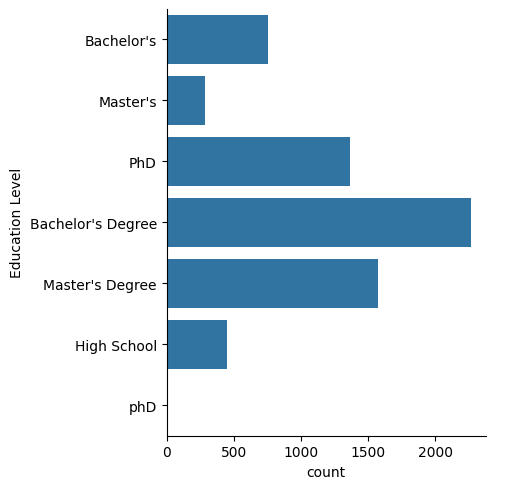

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.catplot(data=df, y="Education Level", kind="count")
plt.show() 

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,6702.0,33.620859,7.614633,21.0,28.0,32.0,38.0,62.0
Years of Experience,6701.0,8.094687,6.059003,0.0,3.0,7.0,12.0,34.0
Salary,6699.0,115326.964771,52786.183911,350.0,70000.0,115000.0,160000.0,250000.0


Edad: La edad minima de las personas entrevistadas es de 21 y la edad máxima es de 62, con un promedio de 62 años.
Años de experiencia: En la pobación encuestada se observan personas sin experencia hasta personas con experiencia de 34 años con una media de 8 años.
Salarios: Los salarios de la población encuestada van desde 350 hasta 250000

Visualización de los datos por genero

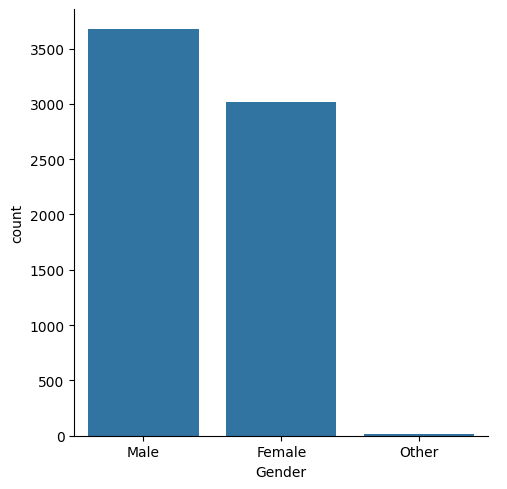

In [6]:
#Por genero
import seaborn as sns
import matplotlib.pyplot as plt


sns.catplot(data=df, x="Gender", kind="count")
plt.show() 

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Years of Experience'}>],
       [<Axes: title={'center': 'Salary'}>, <Axes: >]], dtype=object)

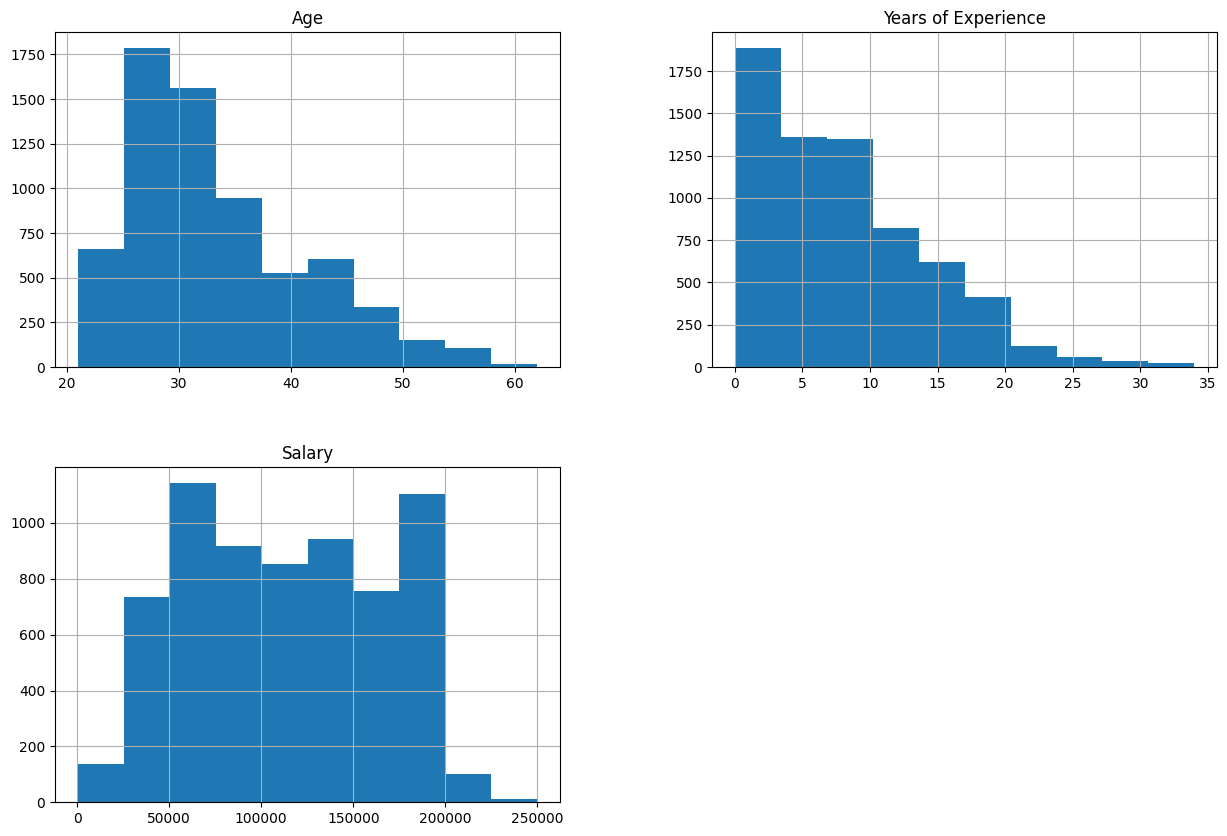

In [7]:

df.hist(figsize=(15,10))

<Axes: xlabel='Years of Experience', ylabel='Salary'>

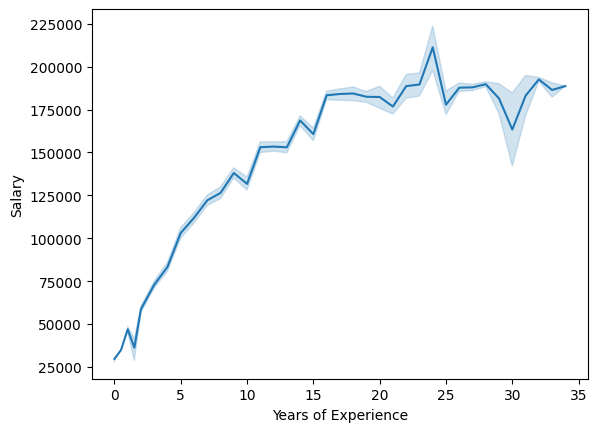

In [8]:
sns.lineplot(data = df,x = "Years of Experience",y = "Salary")

<Axes: xlabel='Age', ylabel='Salary'>

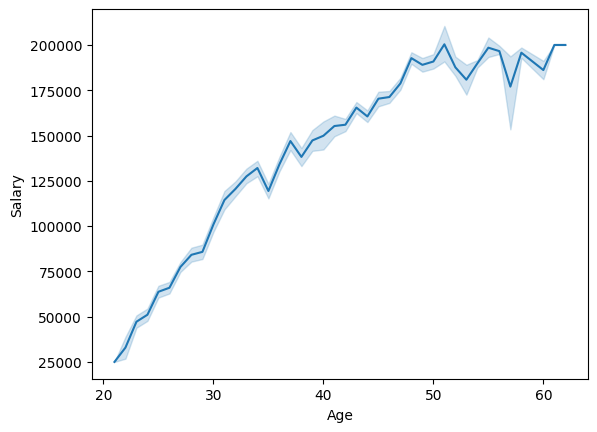

In [9]:
sns.lineplot(data = df,x = "Age",y = "Salary")

Se observa que la edad y los años de experiencia ayudan a describir muy bien la variable objetivo, ya que en la medida que los encuestados tienen mayos edad y por tanto mayo experiencia, nu nivel de salario también aumenta.

## 3.2. Proprocesamiento de los datos

A continuación se realizarán las funciones que permitiran usar el conjunto de datos 'Salary_data', con el que se pretende predecir cuál será el salario de una persona, dependiendo de su nivel académico, años de experiencia, cargo al que aspira.

Creación de la clase para ajustar las variable categorica de nivel educativo

In [7]:
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import OneHotEncoder

class pre:
    def creation_data(self, path_csv):
        df = pd.read_csv(path_csv)
        return df
    def declaration_var(self, data, target):
        target_1 = data[target]
        features = data.drop(target, axis=1)
        names_f = {name:set() for name in features}
        for i in features:
            index_drop = features[i][features[i].isnull() == True].index
            features.drop(index_drop, inplace = True)    
            target_1.drop(index_drop, inplace = True)
        for i in features:
            for j in features[i]:
                names_f[i].add(j)   
        index_targ = target_1[target_1.isnull() == True].index
        target_1.drop(index_targ, inplace=True)   
        features.drop(index_targ, inplace=True)                    
        return target_1, features, names_f
    def replace(self, variable, var_1, var_2, features):
        new_values = [var_1 if value == var_1 or value == var_2 else value for value in features[variable]]
        features[variable] = new_values
        return features

Importación de las librerías que se usarán

In [8]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error

processing = pre()

Definición del conjunto de datos del que se hará uso y la variable objetivo, junto a las demás variables

In [11]:
from sklearn.compose import ColumnTransformer
x = r'C:\Users\Pili\Documents\Maestria 2023\3 Cuatrimestre\ML2\Prediccion-salarios\Salary_Data.csv'
#x = r'C:\Users\santi\OneDrive - Universidad Pedagogica Nacional\El_bosque\tercer_semestre\machine_learning_ll\proyecto\Salary_Data.csv'
data = pre().creation_data(x)
target, features, names_f = pre().declaration_var(data, 'Salary')

Luego de definir el target y features, se determina que las variables "Age","Years of Experience" pueden tener un diferente tipo de formato, con el que se consuma menos recursos computacionales.

También, se encontró que en la variable Education Level, poseía errores tipográficos, donde los diferentes elementos que lo conforman estaban nombrados de diferente forma, apesar de representar el mismo objeto.

Por ejemplo, Bachelor's Degree representa una persona con un título de bachiller y Bachelor's es la forma en la que se puede resumir a una persona con el mismo título. Por lo tanto, ambos elementos comparten las mismas características y deben tomarse como objeto único.


In [42]:

# Cambiar el tipo de formato
features['Age'] = features['Age'].astype('int16')
features['Years of Experience'] = features['Years of Experience'].astype('int64')

# Unir las variables repetidas
features = pre().replace('Education Level', "Bachelor's", "Bachelor's Degree", features)
features = pre().replace('Education Level', "Master's", "Master's Degree", features)
features = pre().replace('Education Level', "PhD", "phD", features)

num_features = ['Age', 'Years of Experience']
cat_features = ['Gender', 'Education Level', 'Job Title']

Se define los pipelines para las variables categóricas y numéricas, además se transforma en el tipo de dato correcto para que se pueda entrenar con los diferentes modelos de regresión

## 4. Entrenamiento del Modelo 

In [43]:

def pipe(categorical_features, features):
    num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    cat_transformer = Pipeline(steps=[('one_hot', OneHotEncoder(handle_unknown='ignore'))])
    return num_transformer, cat_transformer

def column_trans(num_transformer, num_features, cat_transformer, cat_features):
    preprocessor = ColumnTransformer(
        transformers=[
            ('numerical', num_transformer, num_features),
            ('categorical', cat_transformer, cat_features)
        ]
    )
    return preprocessor

num_transformer, cat_transformer = pipe(cat_features, features)
preprocessor = column_trans(num_transformer, num_features, cat_transformer, cat_features)

## Models

Con esta función se crean diferentes modelos de regresión como Lineal, RandomForest, Ridge

In [44]:
def gen_pipe( preprocessor):
    models = []    
    pipeline_ml = Pipeline(
        steps = [('preprocessor_column', preprocessor),
                ('linear_model', LinearRegression())])
    models.append(pipeline_ml)
        
    pipeline_ridge = Pipeline(
        steps = [('preprocessor_column', preprocessor),
                ('model_ridge', Ridge(alpha=0.2))])
    models.append(pipeline_ridge)
    pipeline_rf = Pipeline(
        steps=[('preprocessor_column', preprocessor),
            ('random_forest', RandomForestRegressor(n_estimators=200))])
    models.append(pipeline_rf)
    
    return models

División de los datos de entrenamiento y de prueba

In [45]:
from sklearn.model_selection import train_test_split 
from sklearn.utils import resample

X_train, X_test,y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
models = gen_pipe(preprocessor)

In [46]:
models_metrics = {i:[] for i in range(len(models)) }



for i in models_metrics:
    n_bootstraps = 1000
    model = models[i].fit(X_train, y_train)
    prediction = model.predict(X_test)
    bootstraps_predict = []
    
    for _ in range(n_bootstraps):
        muestras_bootstrap = resample(prediction)
        statics_bootstrap = np.mean(muestras_bootstrap)
        bootstraps_predict.append(statics_bootstrap)

    int_conf = np.percentile(bootstraps_predict, [5, 95])
    
    for j in range(len(int_conf)):
        int_conf[j] = round(int_conf[j], 2)
    
    r2 = r2_score(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)
    rmse = np.sqrt(mean_squared_error(y_test, prediction))
    list_1 = [r2,mse,rmse, int_conf]
    models_metrics[i] = [metrics for metrics in list_1]
    
    
        


In [47]:
names = ['LinearRegression', 'Ridge', 'RandomForestRegressor']
index_final = ['R2', 'mse', 'rmse', 'intervalo de confianza']

#Agregar más métricas de desempeño f1, recall, intervalos de confianza, cross_validation, 
#Agregar matrices de confusión, flasos positivos y demás


models_metrics = pd.DataFrame(data = models_metrics,index = index_final)
models_metrics.columns = names
models_metrics

,LinearRegression,Ridge,RandomForestRegressor
R2,0.840184,0.840205,0.974761
mse,455709421.883616,455648120.237456,71968237.925818
rmse,21347.351636,21345.915774,8483.40957
intervalo de confianza,"[112831.9, 117085.44]","[112780.13, 117114.95]","[112551.69, 117297.71]"


In [48]:
from sklearn.utils import resample 



## 5. Ajuste de hiperparametros

## 6. Conclusiones